In [342]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')

In [343]:
df_train = pd.read_csv('data/train.csv')

train_size = df_train.shape[0]
print('Train Set Size: {} '.format(train_size))

df_test = pd.read_csv('data/test.csv')

test_size = df_test.shape[0]
print('Test Set Size: {} '.format(test_size))

all_data = pd.concat([df_train, df_test], sort=False)

Train Set Size: 1460 
Test Set Size: 1459 


In [344]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [345]:
df_train.get_dtype_counts()

float64     3
int64      35
object     43
dtype: int64

---

## 1 - Exploratory Data Analysis

The objective of this step is to know the data, the relations between the variables and the distributions of the features.

---

In [346]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [347]:
df_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


#### 1.1 - Numeric Features

In [348]:
numeric_features = df_train.select_dtypes(exclude=['object']).columns

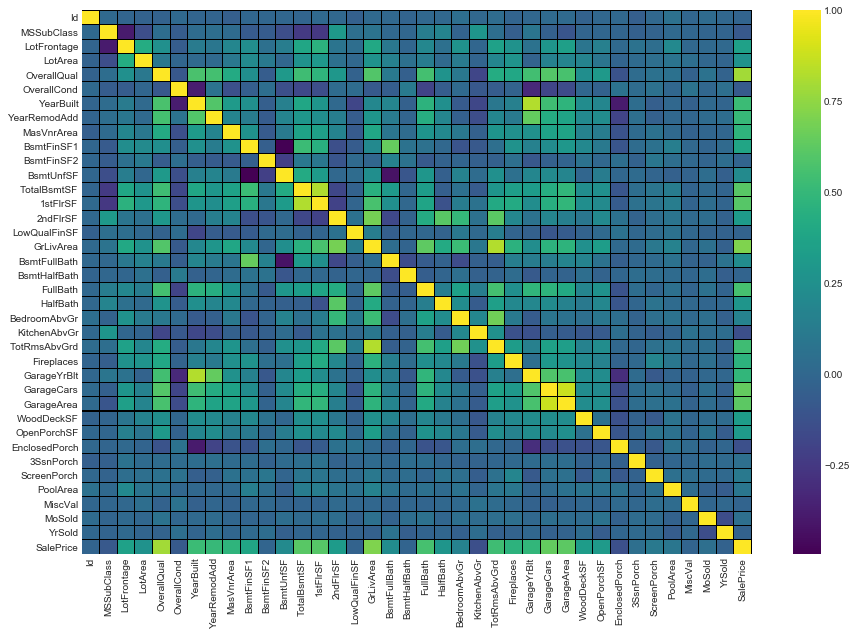

In [349]:
# Plot a heatmap to understand how the features are correlated with the target (SalePrice).
plt.figure(figsize=(15,10))
sns.heatmap(df_train[numeric_features].corr(), cmap='viridis', linewidths=.01, linecolor='black')

- `OverallQual`, `GrLivArea`, `GarageCars` and some others are highly correlated with the `SalePrice`

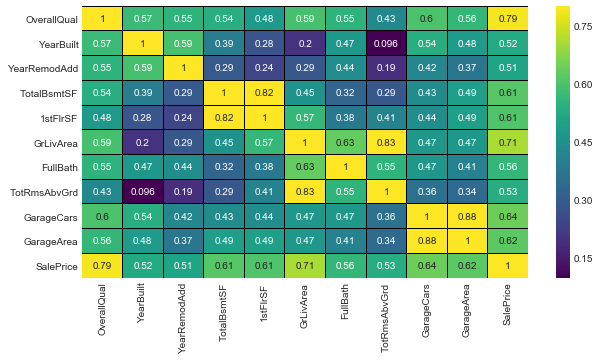

In [350]:
# Selecting the most correlated features with the Sale Price...(0.5 threshold)
price_correlation = df_train.corr()
price_correlation = price_correlation[price_correlation > 0.5]['SalePrice'].dropna()

# Plotting a simplified version of the heatmap for better understanding.
plt.figure(figsize=(10,5))
sns.heatmap(df_train[price_correlation.index].corr(), cmap='viridis', linewidths=.02, annot=True, linecolor='black', vmax=0.8)

- `OverallQual`, `TotalBsmtSF`, `1stFlrSF`, `GrLivArea`, `GarageCars` and `GarageArea` are strongly correlated w/ `SalePrice`.
- `TotalBsmtSF` and `1stFlrSF` are strongly correlated.
- `GrLivArea` and `TotRmsAbvGrd` are strongly correlated.
- `GarageCars` and `GarageArea`are strongly correlated.

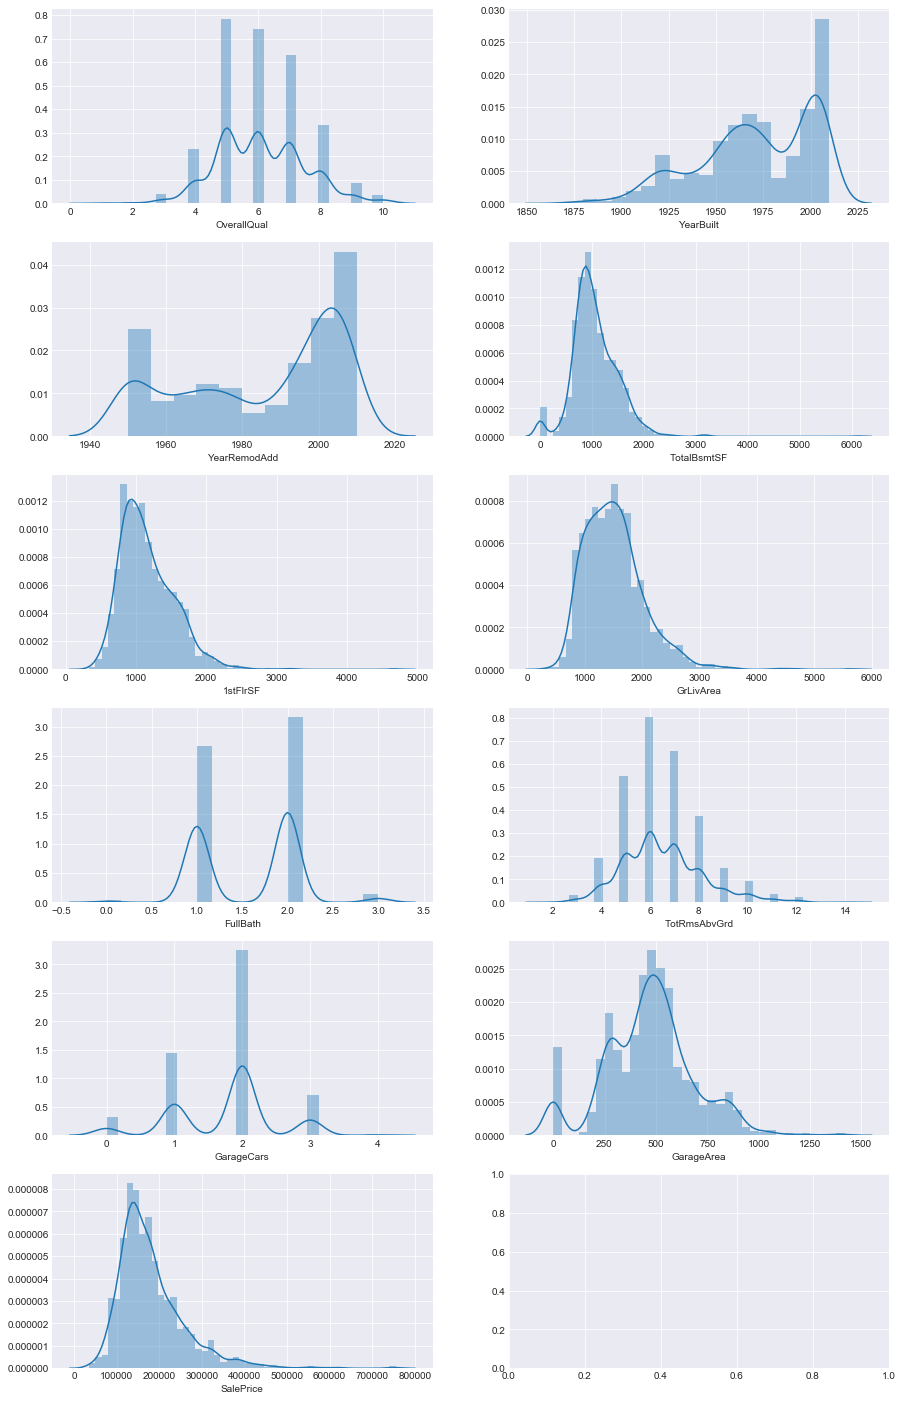

In [351]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15,25))
sns.distplot(df_train['OverallQual'], ax=axes[0,0])
sns.distplot(df_train['YearBuilt'], ax=axes[0,1])
sns.distplot(df_train['YearRemodAdd'], ax=axes[1,0])
sns.distplot(df_train['TotalBsmtSF'], ax=axes[1,1])
sns.distplot(df_train['1stFlrSF'], ax=axes[2,0])
sns.distplot(df_train['GrLivArea'], ax=axes[2,1])
sns.distplot(df_train['FullBath'], ax=axes[3,0])
sns.distplot(df_train['TotRmsAbvGrd'], ax=axes[3,1])
sns.distplot(df_train['GarageCars'], ax=axes[4,0])
sns.distplot(df_train['GarageArea'], ax=axes[4,1])
sns.distplot(df_train['SalePrice'], ax=axes[5,0])

- `OverallQual`, `YearBuilt`, `YearRemodAdd`, `TotalBsmtSF`, `1stFlrSF`, `GrLivArea`, `FullBath`, `TotRmsAbvGrd`, `GarageCars`, `GarageArea` and `SalePrice` are not normally distributed - Maybe a transformation will be required.

---

#### 1.2 - Categorical Features

In [352]:
categorical_features = df_train.select_dtypes(include=['object']).columns

In [353]:
# Based on the data descrption, i will first split the categorical features in two groups: ordinal and nominal.
ordinal_features = ['GarageCond', 'GarageQual', 'GarageFinish', 'BsmtExposure', 'BsmtCond', 'BsmtQual', 'KitchenQual',
                    'ExterQual', 'ExterCond', 'HeatingQC']

nominal_features = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
                    'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
                    'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
                    'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtFinType1',
                    'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'Functional',
                    'FireplaceQu', 'GarageType', 'PavedDrive', 'PoolQC', 'Fence',
                    'MiscFeature', 'SaleType', 'SaleCondition']

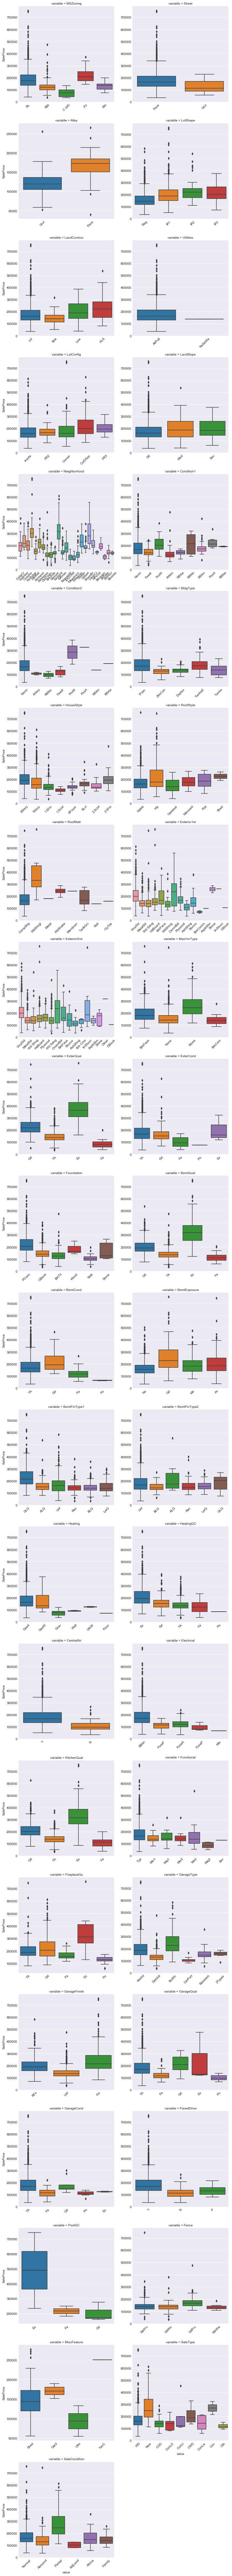

In [354]:
def bxplot(x,y,**kwargs):
    sns.boxplot(x=x,y=y)
    x = plt.xticks(rotation=45)
f = pd.melt(df_train, id_vars=['SalePrice'], value_vars=categorical_features)
g = sns.FacetGrid(f, col='variable', col_wrap=2, size=5, sharex=False, sharey=False,)
g.map(bxplot, 'value', 'SalePrice')

- Since there are a lot of nominal features, with multiple categories, maybe it would be a good ideia to group some of he categories for dimensionality reduction.

#### 1.3 - Missing Values

In [355]:
def missing_ratio():
    missing = (df_train.isnull().sum() / df_train.shape[0]) * 100
    df_nulls = pd.DataFrame(data={'Column': missing.index.values, 'Count': df_train.isnull().sum().values, 'Ratio': missing.values})
    df_nulls.sort_values(by='Ratio', ascending=False, inplace=True)
    return df_nulls

In [356]:
null_ratios = missing_ratio()
null_ratios[null_ratios['Count'] > 0]

,Column,Count,Ratio
72,PoolQC,1453,99.520548
74,MiscFeature,1406,96.301370
6,Alley,1369,93.767123
73,Fence,1179,80.753425
57,FireplaceQu,690,47.260274
3,LotFrontage,259,17.739726
59,GarageYrBlt,81,5.547945
64,GarageCond,81,5.547945
58,GarageType,81,5.547945
60,GarageFinish,81,5.547945


- `PoolQC`, `MiscFeature`, `Alley`, `Fence` and `FireplaceQu` have too many null values. I'm not inputing these features because an input of more than 50% would distort the feature too much.

In [357]:
# Checking LotFrontage...
df_train[df_train['LotFrontage'].isnull()].head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
12,13,20,RL,NaN,12968,Pave,NaN,IR2,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,144000
14,15,20,RL,NaN,10920,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,GdWo,NaN,0,5,2008,WD,Normal,157000
16,17,20,RL,NaN,11241,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,700,3,2010,WD,Normal,149000
24,25,20,RL,NaN,8246,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,5,2010,WD,Normal,154000
31,32,20,RL,NaN,8544,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2008,WD,Normal,149350
42,43,85,RL,NaN,9180,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,12,2007,WD,Normal,144000
43,44,20,RL,NaN,9200,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,7,2008,WD,Normal,130250
50,51,60,RL,NaN,13869,Pave,NaN,IR2,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2007,WD,Normal,177000
64,65,60,RL,NaN,9375,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,NaN,0,2,2009,WD,Normal,219500


-  Replace the NaN's in `LotFrontage` with the neighborhood's median.

In [358]:
# GarageCond. Check if theres a house with GarageArea specified but no GarageCond
df_train[((df_train['GarageArea'] > 0) & (df_train['GarageCond'].isnull()))][['GarageArea', 'GarageCars', 'GarageCond']]

,GarageArea,GarageCars,GarageCond


In [359]:
# GarageType. Check if theres a house with GarageArea specified but no GarageType
df_train[((df_train['GarageArea'] > 0) & (df_train['GarageType'].isnull()))][['GarageArea', 'GarageCars', 'GarageCond']]

,GarageArea,GarageCars,GarageCond


In [360]:
# GarageFinish. Check if theres a house with GarageArea specified but no GarageFinish
df_train[((df_train['GarageArea'] > 0) & (df_train['GarageFinish'].isnull()))][['GarageArea', 'GarageCars', 'GarageCond']]

,GarageArea,GarageCars,GarageCond


In [361]:
# GarageQual. Check if theres a house with GarageArea specified but no GarageQual
df_train[((df_train['GarageArea'] > 0) & (df_train['GarageQual'].isnull()))][['GarageArea', 'GarageCars', 'GarageCond']]

,GarageArea,GarageCars,GarageCond


In [362]:
# GarageYrBlt. Check if theres a house with GarageArea specified but no GarageYrBlt
df_train[((df_train['GarageArea'] > 0) & (df_train['GarageYrBlt'].isnull()))][['GarageArea', 'GarageCars', 'GarageCond']]

,GarageArea,GarageCars,GarageCond


- Replace the NaN values in `GarageCond`, `GarageType`, `GarageFinish`, `GarageQual` and `GarageYrBlt` with "NA", wich means "NO GARAGE".

In [363]:
#Checking BsmtXXX features...
df_train[df_train['BsmtFinType2'].isnull()][['TotalBsmtSF','BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinSF1',
                                             'BsmtFinType2','BsmtFinSF2','BsmtUnfSF','BsmtExposure']].head(10)

,TotalBsmtSF,BsmtQual,BsmtCond,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,BsmtExposure
17,0,NaN,NaN,NaN,0,NaN,0,0,NaN
39,0,NaN,NaN,NaN,0,NaN,0,0,NaN
90,0,NaN,NaN,NaN,0,NaN,0,0,NaN
102,0,NaN,NaN,NaN,0,NaN,0,0,NaN
156,0,NaN,NaN,NaN,0,NaN,0,0,NaN
182,0,NaN,NaN,NaN,0,NaN,0,0,NaN
259,0,NaN,NaN,NaN,0,NaN,0,0,NaN
332,3206,Gd,TA,GLQ,1124,NaN,479,1603,No
342,0,NaN,NaN,NaN,0,NaN,0,0,NaN
362,0,NaN,NaN,NaN,0,NaN,0,0,NaN


- Replace `BsmtQual`, `BsmtCond`, `BsmtFinType1`, `BsmtFinType2` and `BsmtExposure` "NaN's" with "NA" when `TotalBsmtSF` = 0;
- Replace `BsmtQual`, `BsmtCond`, `BsmtFinType1`, `BsmtFinType2` and `BsmtExposure` "NaN's" with "None" when `TotalBsmtSF` > 0;

In [364]:
# MasVnrArea and MasVnrType...
df_train[df_train['MasVnrArea'].isnull()][['MasVnrArea','MasVnrType']]

,MasVnrArea,MasVnrType
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN
977,NaN,NaN
1243,NaN,NaN
1278,NaN,NaN


- Replace `MasVnrArea`NaN's with 0;
- Replace `MasVnrType`NaN's with "None";

In [383]:
# ELectrical
df_train[df_train['Electrical'].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1379,1380,80,RL,73.0,9735,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2008,WD,Normal,167500


- Replace `Electrical` NaN (single observation) with the most common value: SBrkr;

## 2 - Preprocessing

#### 2.1 - Missing Values

In [365]:
# Replace the NaN's in LotFrontage with the neighborhood's median.
by_neighbor = df_train.groupby(by='Neighborhood', sort=True)

def neighborhood_median(row):
    median = by_neighbor['LotFrontage'].median()[row['Neighborhood']]
    return median

df_train['LotFrontage'] = df_train.apply(lambda row: neighborhood_median(row) if np.isnan(row['LotFrontage']) else row['LotFrontage'], axis=1)

In [366]:
# Replace the NaN values in GarageCond, GarageType, GarageFinish, GarageQual and GarageYrBlt with "NA", wich means "NO GARAGE".
df_train.fillna({'GarageCond': 'NA', 
                 'GarageType': 'NA', 
                 'GarageFinish': 'NA', 
                 'GarageQual': 'NA', 
                 'GarageYrBlt': 'NA'}, inplace=True)

In [367]:
# Replace BsmtQual, BsmtCond, BsmtFinType1, BsmtFinType2 and BsmtExposure "NaN's" with "NA" when TotalBsmtSF = 0;
mask = (df_train['TotalBsmtSF'] == 0)
df_train.loc[mask, ['BsmtQual','BsmtCond','BsmtFinType1','BsmtFinType2','BsmtExposure']] = "NA"

# Replace BsmtQual, BsmtCond, BsmtFinType1, BsmtFinType2 and BsmtExposure "NaN's" with "None" when TotalBsmtSF > 0;
mask = (df_train['TotalBsmtSF'] > 0)
df_train.loc[mask, ['BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'BsmtExposure']] = "None"

In [368]:
# Replace MasVnrArea NaN's with 0;
# Replace MasVnrType NaN's with "None";
df_train.fillna({'MasVnrArea': 0, 'MasVnrType': 'None'}, inplace=True)

---

#### 2.2 - Outliers

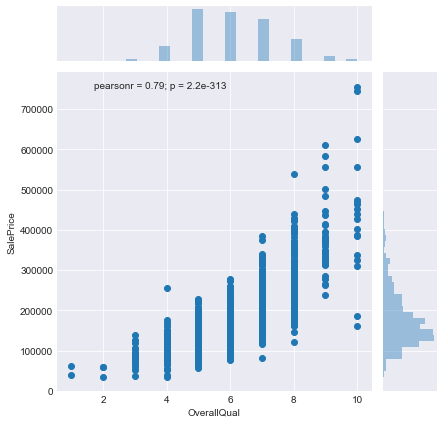

In [371]:
sns.jointplot(data=df_train, x='OverallQual', y='SalePrice')

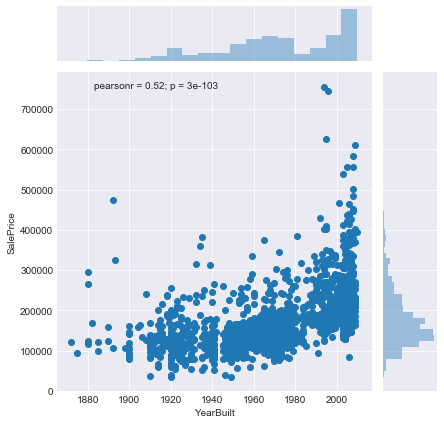

In [372]:
sns.jointplot(data=df_train, x='YearBuilt', y='SalePrice')

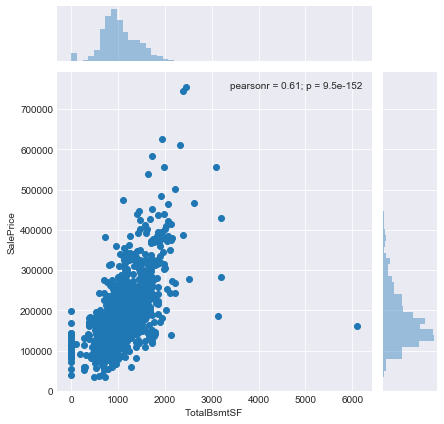

In [373]:
sns.jointplot(data=df_train, x='TotalBsmtSF', y='SalePrice')

In [374]:
# This house seem to be an outlier because of its low price and the TotalBsmtSF value.
df_train[df_train['TotalBsmtSF'] > 6000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


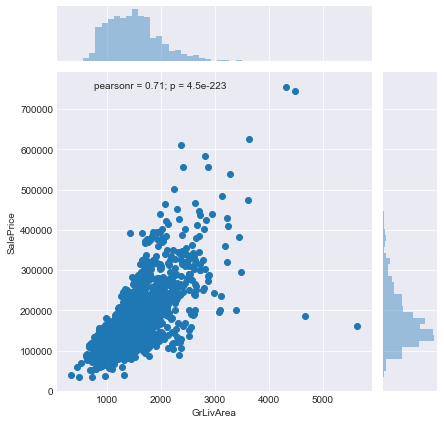

In [375]:
sns.jointplot(data=df_train, x='GrLivArea', y='SalePrice')

In [376]:
# These two houses also seem to be outliers because of their low price.
df_train[df_train['GrLivArea'] > 4500]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


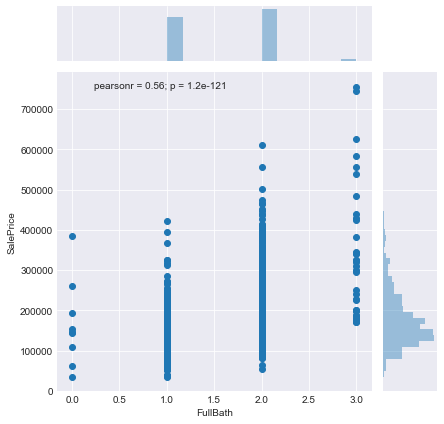

In [377]:
sns.jointplot(data=df_train, x='FullBath', y='SalePrice')

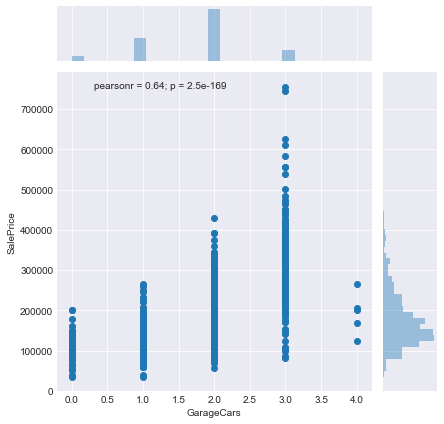

In [378]:
sns.jointplot(data=df_train, x='GarageCars', y='SalePrice')

#### Removing Outliers

In [379]:
df_train.drop([523, 1298], inplace=True)

NameError: name 'selected_features' is not defined

In [ ]:
sns.jointplot(data=selected_features, x='TotalBsmtSF', y='SalePrice')

In [ ]:
sns.jointplot(data=selected_features, x='GrLivArea', y='SalePrice')

In [ ]:
# Checking correlations between the selected features to avoid multicolinearity.
#plt.figure(figsize=(15,10))
#sns.heatmap(selected_features.corr(), cmap='viridis', linewidths=.01, annot=True, vmax=0.8)

In [ ]:
#Removing highly correlated features

# TotalBsmtSF and 1stFlrSF - Keeping TotalBsmtSF
#selected_features.drop('1stFlrSF', axis=1, inplace=True)
# GrLivArea and TotRmsAbvGrd - Keeping GrLivArea because of higher correlation with SalePrice.
#selected_features.drop('TotRmsAbvGrd', axis=1, inplace=True)
# GarageCars and GarageArea - Keeping GarageCars because of higher correlation with SalePrice.
#selected_features.drop('GarageArea', axis=1, inplace=True)

In [ ]:
ord_values = {'GarageCond' : {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
              'GarageQual' : {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
              'GarageFinish': {'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3},
              'BsmtExposure': {'NA': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4},
              'BsmtCond' : {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
              'BsmtQual' : {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
              'KitchenQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
              'ExterQual':  {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
              'ExterCond': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
              'HeatingQC': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}}

dummy = 'GarageType', 'MSZoning', 'Exterior1st', 'PavedDrive','LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'Foundation', 'Street', 'CentralAir',

## Engineering

## Model And Validation

## Submission